# Remark:
The notebook was produced  with Anaconda 3 2021.11 with scikit-learn updated to version 1.0.2 and mlxtend 0.19

# 0. Library imports and parameter(s) declaration

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from functools import partial
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.model_selection import ParameterGrid

random_state = 42 # set in order to guarantee repetability of results
data_url1 = 'exam_superv.csv'
data_url2 = 'exam_unsuperv.csv'
sep1=','
sep2 = ','

# 1. Load the exam_superv.csv and explore the data, showing size, structure and histograms of numeric data; show the histogram of the frequencies of the class labels, contained in the “y” column .
First, the dataset is loaded and the size and the first rows are shown

In [2]:
df_super = pd.read_csv(data_url1, sep=sep1)
print("The dataset has {} rows and {} columns".format(df_super.shape[0], df_super.shape[1]))
df_super.head()

The dataset has 1200 rows and 4 columns


,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


Then, the statistical description of numerical data (excluding class) is shown:

In [3]:
# in order to correctly show the class as discrete value in the describe(), a mapping is applied
convert_to_str = 'y'
df_super_num = df_super.copy()
df_super_num[convert_to_str] = df_super_num[convert_to_str].astype(str)
cat_attributes = df_super_num.dtypes.loc[df_super_num.dtypes=='object'].index.values

df_super_num.describe() # describes only numerical attributes

,0,1,2
count,1200.000000,1200.000000,1200.000000
mean,2.391668,1.996186,2.494236
std,0.804770,0.507227,0.589235
min,0.343023,0.509424,1.500260
25%,1.806657,1.809635,1.974389
50%,2.744439,1.983524,2.469778
75%,3.092275,2.201484,2.995198
max,3.529782,3.647299,3.498523


In [4]:
df_super_num[cat_attributes].describe()

,y
count,1200
unique,2
top,1
freq,609


The histograms for both numeric attributes and class are shown:


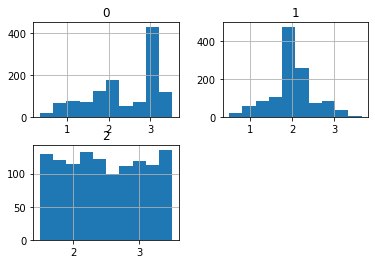

In [5]:
df_super_num.hist();

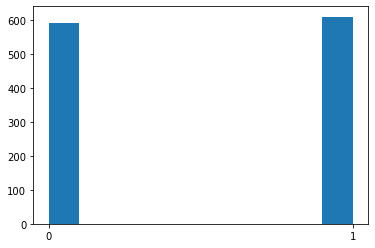

In [6]:
class_label = 'y'
plt.hist(df_super_num[class_label]);

# 2. drop the column “y” and find the best clustering scheme and hyper–parameters able to reproduce the y column 

(hint: before clustering you can consider dropping columns with little correlation to “y”; perhaps 
you should consider more than one estimator for clustering) .

In [7]:
# drop the class column
X = df_super_num.drop(class_label, axis=1)
y = df_super_num[class_label]


Before applying clustering, and since we have only 3 columns in x, we'll drop the one with the least correlation with the class through SelectKBest 

In [8]:
kbest = SelectKBest(score_func=partial(mutual_info_classif,random_state=random_state), k=X.shape[1]-1)

fit = kbest.fit(X,y)
X_red = fit.transform(X)
pd.DataFrame(X_red).head()

,0,1
0,1.589942,2.977770
1,2.908437,1.837522
2,3.284091,1.818476
3,3.148717,2.071991
4,2.116881,2.133874


We can see that the last column was dropped.

Then we'll consider first a Kmeans estimator, searching for the best number of k, and then an optimized dbscan.
Then we will compare the results and decide which is the best clustering scheme for replying the class column

starting from KMeans we will choose the value k=2 since we want to reproduce the the class label. Also we don't have any other hyper parameter to set

In [9]:
k = len(np.unique(y))
kmeans = KMeans(n_clusters=k, random_state=random_state)
y_km = kmeans.fit_predict(X_red)

Then, we will see visually if the the estimator is good through a scatterplot. 

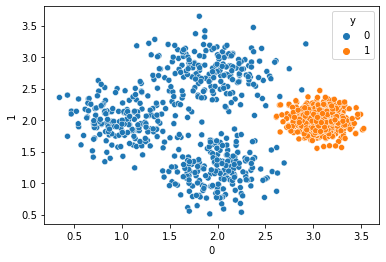

In [10]:
chosen_dim = [0,1]
plot_data = pd.DataFrame(X_red)
plot_data[class_label] =  y
sns.scatterplot(x = chosen_dim[0],y = chosen_dim[1],data=plot_data, hue = class_label);

This is the clustering obtained with golden standard

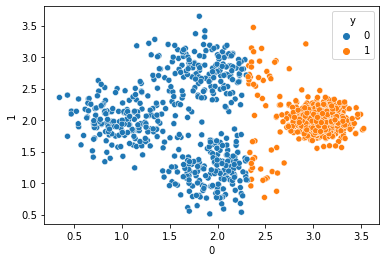

In [11]:
chosen_dim = [0,1]
plot_data2 = pd.DataFrame(X_red)
plot_data2[class_label] =  y_km
sns.scatterplot(x = chosen_dim[0],y = chosen_dim[1],data=plot_data2,hue = class_label);

The result is not so bad, even if we have a lot of errors in the two main "central clusters". Sowe should try with DBSCAN, starting from the optimization of hyperparameters

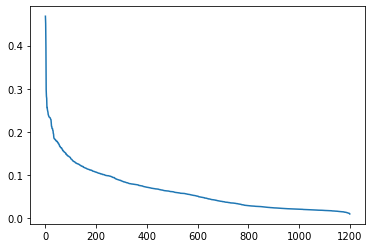

In [12]:
# we start from getting a good extimate for the hyperparameter as suggested in the orginal paper
min_points=2*X_red.shape[1]
k_distances = []
for i in range(0, X_red.shape[0]):
    k_point_distances = []
    for j in range(0, X_red.shape[0]):
        if i!=j:
            dist = np.sqrt(sum((X_red[i,:]-X_red[j,:])**2))
            k_point_distances.append(dist)
    k_point_distances.sort()
    k_distances.append(k_point_distances[min_points-1])
    
k_distances.sort(reverse=True)
plt.plot(range(0,len(k_distances)), k_distances)
plt.show()

So we can use a value of minpoints around 4 (2*number of attributes) and a value of eps around 0.2 (elbow of the curve)
our choice will be driven by the number of clusters, the silhouette score and the number of unclustered values

In [13]:
grid = {'eps':list(np.arange(0.1 ,0.3, 0.01)), 'min_samples':list(range(min_points-3,min_points+3,1))}
params = list(ParameterGrid(grid))
sil_thr = 0.56  # visualize results only for combinations with silhouette above the threshold
columns = ["eps", "min_samples", "n_clusters", "silhouette", "unclust%"]
result = pd.DataFrame(columns=columns)
required_clusters = len(np.unique(y))


for i in params:
    grid_est = DBSCAN(eps=i['eps'], min_samples=i['min_samples'])
    yge = grid_est.fit_predict(X_red)
    labels = np.unique(yge)
    if -1 in labels:
        n=1
    else:
        n=0
    uncl_ratio = np.count_nonzero(yge==-1)/len(yge)*100
    n_clusters = np.count_nonzero(labels>-1)
    y_no_noise = yge[yge!=-1]
    
    if len(labels)-n < 2:
        sil_score=-1
        sdi=-1
    else:
        sil_score = silhouette_score(X_red[yge!=-1], y_no_noise)
        
    if n_clusters==required_clusters and sil_score>sil_thr:
        result = result.append({ 'eps': i["eps"],
                                'min_samples':i["min_samples"],
                                'n_clusters':n_clusters,
                                'silhouette':sil_score,
                                'unclust%':uncl_ratio}, ignore_index=True)
        
print(result)

    eps  min_samples  n_clusters  silhouette  unclust%
0  0.15          4.0         2.0    0.571673  2.666667
1  0.16          4.0         2.0    0.566636  1.750000
2  0.16          5.0         2.0    0.569389  2.250000
3  0.17          4.0         2.0    0.563942  1.333333
4  0.17          5.0         2.0    0.566375  1.666667
5  0.18          4.0         2.0    0.561564  1.083333
6  0.18          5.0         2.0    0.562483  1.250000
7  0.18          6.0         2.0    0.566400  1.750000
8  0.19          6.0         2.0    0.563013  1.416667


We will choose the entry number 5, which has the lowest unclustering percentage and a fairly high silhouette score

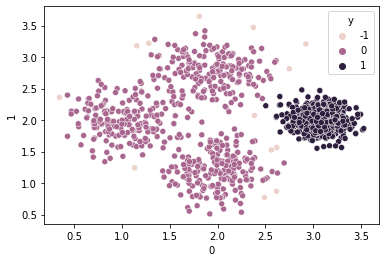

In [14]:
chosen_hyper_db = {'eps':0.18, 'min_samples':4}
dbscan = DBSCAN(eps = chosen_hyper_db['eps'], min_samples=chosen_hyper_db['min_samples'])
y_db = dbscan.fit_predict(X_red)

chosen_dim = [0,1]
plot_data3 = pd.DataFrame(X_red)
plot_data3[class_label] =  y_db
sns.scatterplot(x = chosen_dim[0],y = chosen_dim[1],data=plot_data3,hue = class_label);

The second estimator will be chosen.

# 4. show the difference between the original “y” column and the labels gen- erated by the clustering, it can be expressed as “accuracy”, produce also the confusion matrix

In order to correcly have an estimate of the accuracy, clusters (as well as noise points) will be mapped to the highest class they represent

In [15]:
def remap(y_true, y_pred):
    y_mapped = y_pred.copy()
    for lab in np.unique(y_pred):
        true_l, count = np.unique(y_true[y_pred==lab], return_counts=True)
        y_mapped[y_pred==lab] = true_l[np.argmax(count)]
    return y_mapped 

In [16]:
y_db_rem = remap(y, y_db)
print("The accuracy is: {:.2f}%".format(accuracy_score(y,y_db_rem.astype(str))*100))
print("The confusion matrix:")
print(confusion_matrix(y,y_db_rem.astype(str)))

The accuracy is: 99.75%
The confusion matrix:
[[588   3]
 [  0 609]]


As we can see, the result is quite good

# 5. apply the same transformations, to unsuperv2.csv, then apply the best clustering scheme and hyper parameters and plot the data with the assigned labels

In [17]:
df_un = pd.read_csv(data_url2, sep=sep2, header=None)
columns_to_drop = [2]
X2 = df_un.drop(columns_to_drop, axis=1)
X2 = X2.drop(X2.iloc[0], axis=0)
X2.head()

,0,1
2,2.179220,1.410352
3,2.242676,2.624663
4,1.980176,0.836695
5,3.210992,2.251962
6,0.812696,1.944642


In [18]:
dbscan_unsup = DBSCAN(eps = chosen_hyper_db['eps'], min_samples=chosen_hyper_db['min_samples'])

y2 = dbscan_unsup.fit_predict(X2)

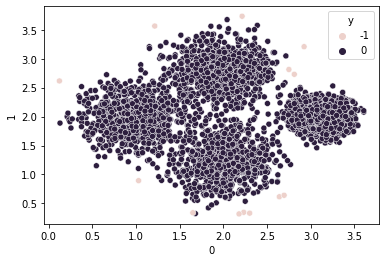

In [20]:
chosen_dim = [0,1]
plot_data4 = pd.DataFrame(X2)

plot_data4[class_label] =  y2
sns.scatterplot(x = chosen_dim[0],y = chosen_dim[1], data=plot_data4,hue = class_label);

applying The same clustering scheme, however, doesnt' bring the same good results, so probabily a best set of hyperparameter should be chosen